# Kinase Library Tyrosine Kinome Atlas

The Kinase Library is a resource which collects information about kinase phosphorylation sites. The Tyrosine Kinome Atlas dataset uses synthetic peptide libraries to profile substrate sequence specificity.
In this study, 7,315 phosphosites were computationally ranked against each kinase motif. This generated percentiles and rank of kinase-substrate specificity for proteins based on their phosphorylation by 78 canonical tyrosine human kinases.
The kinase-substrate percentile scores and ranking were downloaded from the supplementary information of 

In [2]:
import pandas as pd
import datetime
import numpy as np
import os
import scipy.spatial.distance as dist
import seaborn as sns
import sys
import json
import scanpy as sc
from tqdm import tqdm

# UMAP
from sklearn.feature_extraction.text import TfidfVectorizer
import anndata
from collections import OrderedDict

# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, save, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category20
output_notebook()

from IPython.display import display, HTML, Markdown
sys.setrecursionlimit(100000)

Loading BokehJS ...

## Load Data

In [47]:
tyrosineKinases = pd.read_csv('TyrKinome/41586_2024_7407_MOESM5_ESM/Annotation - with non-canonical-Table 1.csv')
tyrosineKinases

,Database Uniprot Accession,Uniprot Primary Accession,Uniprot Entry,Gene,Alternative Gene Names,Protein,Description,Uniprot,Phosphosite,Database,...,VEGFR2_percentile,VEGFR2_rank,VEGFR3_percentile,VEGFR3_rank,WEE1_TYR_percentile,WEE1_TYR_rank,YES_percentile,YES_rank,ZAP70_percentile,ZAP70_rank
0,A0A087WTJ2,A0A087WTJ2,A0A087WTJ2_HUMAN,GIMAP1-GIMAP5,GIMAP1-GIMAP5,A0A087WTJ2,GIMAP1-GIMAP5 readthrough,A0A087WTJ2,Y14,Ochoa,...,21.43,74,37.76,61,47.45,51,99.67,2,62.11,36
1,A0A0A6YYH1,A0A0A6YYH1,A0A0A6YYH1_HUMAN,C15orf38-AP3S2,C15orf38-AP3S2,A0A0A6YYH1,Arpin,A0A0A6YYH1,Y5,Ochoa,...,33.12,78,50.84,34,40.25,64,46.09,48,15.02,93
2,A0A0A6YYL1,A0A0A6YYL1,A0A0A6YYL1_HUMAN,ST20-MTHFS,ST20-MTHFS,A0A0A6YYL1,5-formyltetrahydrofolate cyclo-ligase (EC 6.3....,A0A0A6YYL1,Y59,Ochoa,...,29.11,19,35.98,17,97.79,1,1.36,80,1.03,86
3,A0A0B4J203,A0A0B4J203,A0A0B4J203_HUMAN,NaN,NaN,A0A0B4J203,Pre-mRNA 3'-end-processing factor FIP1 (EC 2.7...,A0A0B4J203,Y522,Ochoa,...,33.97,67,18.85,82,87.66,4,30.93,69,45.39,57
4,A0A0B4J203,A0A0B4J203,A0A0B4J203_HUMAN,NaN,NaN,A0A0B4J203,Pre-mRNA 3'-end-processing factor FIP1 (EC 2.7...,A0A0B4J203,Y609,Ochoa,...,72.93,31,79.01,25,95.19,3,39.35,77,74.46,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7310,Q9Y6W5,Q9Y6W5,WASF2_HUMAN,WASF2,WASF2 WAVE2,WASF2,Actin-binding protein WASF2 (Protein WAVE-2) (...,Q9Y6W5,Y150,PSP-LT,...,28.74,72,41.41,47,41.71,46,6.50,92,47.38,38
7311,Q9Y6X2,Q9Y6X2,PIAS3_HUMAN,PIAS3,PIAS3,PIAS3,E3 SUMO-protein ligase PIAS3 (EC 2.3.2.-) (E3 ...,Q9Y6X2,Y430,Ochoa,...,47.76,62,42.64,72,19.48,87,32.31,83,66.60,28
7312,Q9Y6Y9,Q9Y6Y9,LY96_HUMAN,LY96,LY96 ESOP1 MD2,LY96,Lymphocyte antigen 96 (Ly-96) (ESOP-1) (Protei...,Q9Y6Y9,Y131,PSP-LT,...,48.74,12,27.14,21,75.70,5,3.54,74,20.86,28
7313,Q9Y6Y9,Q9Y6Y9,LY96_HUMAN,LY96,LY96 ESOP1 MD2,LY96,Lymphocyte antigen 96 (Ly-96) (ESOP-1) (Protei...,Q9Y6Y9,Y22,PSP-LT,...,88.22,11,85.14,13,28.45,84,50.71,58,78.49,20


## Process Data

In [48]:
uniprotToEntrez = pd.read_csv('../../tables/uniprot_to_entrez.tsv', sep='\t').set_index('From')['To'].to_dict()
geneids = pd.read_csv('../../mapping/mappingFiles/GeneSymbolsAndIDs_2024.tsv', sep='\t', index_col='GeneID')['Symbol'].to_dict()
uniprot = pd.read_csv('../../mapping/mappingFiles/humanUniprotMapping.tsv', sep='\t', index_col='UniProt Accession')['NCBI Entrez Gene ID'].astype(int).to_dict()
genemapping = pd.read_csv('../../mapping/mappingFiles/mappingFile_2024.tsv', sep='\t', index_col='Synonyms')
genemapping = genemapping[genemapping['#tax_id']==9606]['Symbol'].to_dict()

In [49]:
matrix = tyrosineKinases.set_index('Uniprot').get(tyrosineKinases.columns[15:])
matrix.index = matrix.index.map(uniprot).map(geneids).map(genemapping)
matrix = matrix.rename_axis('Gene').reset_index().dropna().set_index('Gene').rename_axis('Kinase', axis=1)
matrix = matrix[matrix.columns[:185:2]].rename(lambda x: x.split(sep='_')[0], axis=1)
matrix

Kinase,ABL,ACK,ALK,ARG,AXL,BLK,BMPR2,BRK,BTK,CSFR,...,TRKC,TXK,TYK2,TYRO3,VEGFR1,VEGFR2,VEGFR3,WEE1,YES,ZAP70
Gene,,,,,,,,,,,,,,,,,,,,,
GIMAP1-GIMAP5,36.18,6.22,27.40,46.44,49.64,87.22,78.99,98.40,71.50,26.37,...,57.63,73.82,16.04,27.23,51.22,21.43,37.76,47.45,99.67,62.11
ARPIN-AP3S2,72.93,31.82,45.68,60.52,41.74,34.16,40.25,69.07,47.87,38.26,...,49.90,44.37,44.52,36.18,64.74,33.12,50.84,40.25,46.09,15.02
ST20-MTHFS,3.11,75.58,2.80,2.85,23.33,0.41,33.75,14.55,10.83,9.41,...,0.33,1.95,29.09,11.86,24.97,29.11,35.98,97.79,1.36,1.03
SCN11A,81.77,87.26,41.91,83.34,83.72,54.91,24.01,51.59,63.93,29.72,...,39.29,81.42,13.09,75.40,27.66,33.97,18.85,87.66,30.93,45.39
SCN11A,30.44,30.38,39.00,26.64,60.36,38.28,88.22,62.60,76.95,80.45,...,86.87,56.16,70.65,84.24,80.78,72.93,79.01,95.19,39.35,74.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WASF2,36.44,41.17,28.02,29.06,49.40,11.38,53.31,83.50,39.26,28.08,...,33.01,45.53,28.87,33.25,73.04,28.74,41.41,41.71,6.50,47.38
PIAS3,68.37,80.52,73.25,67.56,72.79,59.79,67.15,54.08,48.43,70.67,...,61.19,34.82,69.73,61.65,16.59,47.76,42.64,19.48,32.31,66.60
LY96,8.40,70.71,12.52,6.74,27.88,1.16,28.91,16.55,4.57,17.77,...,0.28,0.42,4.88,8.86,14.18,48.74,27.14,75.70,3.54,20.86


In [50]:
matrix = matrix.sort_index().groupby(axis=0, level=0).median()
matrix

Kinase,ABL,ACK,ALK,ARG,AXL,BLK,BMPR2,BRK,BTK,CSFR,...,TRKC,TXK,TYK2,TYRO3,VEGFR1,VEGFR2,VEGFR3,WEE1,YES,ZAP70
Gene,,,,,,,,,,,,,,,,,,,,,
AADAC,48.090,63.470,31.23,36.920,42.170,71.79,47.210,6.920,15.690,41.080,...,42.920,38.69,27.290,50.170,25.960,57.540,45.680,82.860,49.90,24.340
AAK1,4.640,11.400,44.93,5.270,7.940,24.60,76.600,38.110,50.650,41.370,...,23.940,18.58,95.770,16.310,10.480,19.590,15.250,93.610,18.82,7.460
AARS1,34.740,52.090,54.26,28.890,77.350,34.43,40.380,91.950,41.890,24.050,...,36.970,47.78,43.120,46.050,32.790,33.010,30.220,27.270,67.50,59.510
ABCA1,87.350,46.600,57.52,83.240,83.240,39.68,79.540,96.230,73.710,95.880,...,79.180,54.35,59.380,73.230,79.180,74.190,87.660,15.320,63.78,90.170
ABCA8,58.425,65.890,35.99,58.470,77.785,35.40,35.535,62.915,48.260,62.495,...,35.740,52.35,33.315,53.415,58.335,65.855,57.990,45.710,49.30,50.995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1,46.180,23.270,14.60,37.450,11.100,60.28,24.470,19.080,24.120,8.990,...,16.870,47.65,12.230,17.530,2.100,4.490,4.810,3.850,30.51,51.390
ZRANB2,46.790,6.525,38.50,63.335,31.935,76.77,96.070,27.080,56.685,71.145,...,80.915,67.77,47.585,30.590,89.855,52.910,88.685,37.435,70.49,78.335
ZSCAN25,75.400,20.110,32.06,83.150,56.210,56.29,98.860,49.330,58.070,74.940,...,87.650,60.49,50.840,24.100,97.330,66.910,93.910,17.570,33.01,98.930


In [53]:
edgelist = matrix.stack().reset_index()
edgelist.columns = ['Gene', 'Kinase', 'Percentile']
edgelist = edgelist.sort_values(['Kinase', 'Percentile'], ascending=[True, False]).reset_index(drop=True)
#edgelist = edgelist.drop_duplicates(['Gene','Kinase'])
print(len(edgelist['Gene'].unique()), 'genes,', len(edgelist['Kinase'].unique()), 'kinases')
edgelist

3161 genes, 93 kinases


,Gene,Kinase,Percentile
0,OPHN1,ABL,99.85
1,CEP89,ABL,99.76
2,GTF2E1,ABL,99.72
3,SRCIN1,ABL,99.66
4,LILRB1,ABL,99.59
...,...,...,...
293968,MMP1,ZAP70,0.20
293969,NAT10,ZAP70,0.20
293970,IFT57,ZAP70,0.09
293971,ZBED5,ZAP70,0.07


In [54]:
edgelist_filtered = pd.DataFrame(columns=['Gene', 'Percentile'])
edgelist = edgelist.set_index('Kinase')
for kinase in edgelist.index.unique():
    edgelist_filtered = pd.concat([edgelist_filtered, edgelist.loc[kinase][:100]])
edgelist = edgelist_filtered.rename_axis('Kinase', axis=0).reset_index().sort_values(['Kinase','Percentile','Gene'],ascending=[True,False,True]).reset_index(drop=True)
print(len(edgelist['Gene'].unique()), 'genes,', len(edgelist['Kinase'].unique()), 'kinases')
edgelist

1457 genes, 93 kinases


,Kinase,Gene,Percentile
0,ABL,OPHN1,99.850
1,ABL,CEP89,99.760
2,ABL,GTF2E1,99.720
3,ABL,SRCIN1,99.660
4,ABL,LILRB1,99.590
...,...,...,...
9295,ZAP70,KCTD12,94.590
9296,ZAP70,RPS14,94.490
9297,ZAP70,KAT2B,94.480
9298,ZAP70,MFAP1,94.410


## Harmonizome Additions

### Dataset

In [8]:
#(id, name, name_without_resource, description, association, gene_set_description, gene_sets_description, attribute_set_description, is_signed, is_continuous_valued, last_updated, directory, num_page_views, resource_fk, measurement_fk, dataset_group_fk, attribute_type_fk, attribute_group_fk, evidence_type, evidence_group, measurement_bias, attribute_type_plural)
(156,
'Kinase Library Tyrosine Kinome Atlas',
'Tyrosine Kinome Atlas',
'A phosphoproteomics atlas detailing phosphorylation of protein substrates by 93 canonical and non-canonical tyrosine kinases in the human kinome.',
'substrate-kinase associations from high-thorughput and low-thoroughput phosphoproteomics data',
'substrates of the kinase {0} from the Kinase Library Tyrosine Kinome Atlas dataset.',
'sets of substrates of kinases from the Kinase Library Tyrosine Kinome Atlas dataset.',
'kinases that phosphorylate {0} protein from the Kinase Library Tyrosine Kinome Atlas dataset.',
0,
1,
'2024-09-24',
'tyrkinaselib',
0,
102,
25,
5,
30,
5,
'protein phosphorylation by PSPA',
'primary experimental data',
'mixed',
'kinases')

(156,
 'Kinase Library Tyrosine Kinome Atlas',
 'Tyrosine Kinome Atlas',
 'A phosphoproteomics atlas detailing phosphorylation of protein substrates by 93 canonical and non-canonical tyrosine kinases in the human kinome.',
 'substrate-kinase associations from high-thorughput and low-thoroughput phosphoproteomics data',
 'substrates of the kinase {0} from the Kinase Library Tyrosine Kinome Atlas dataset.',
 'sets of substrates of kinases from the Kinase Library Tyrosine Kinome Atlas dataset.',
 'kinases that phosphorylate {0} protein from the Kinase Library Tyrosine Kinome Atlas dataset.',
 0,
 1,
 '2024-09-24',
 'tyrkinaselib',
 0,
 102,
 25,
 5,
 30,
 5,
 'protein phosphorylation by PSPA',
 'primary experimental data',
 'mixed',
 'kinases')

### Publication

In [9]:
#(id, long_citation, short_citation, url, pmid, pubmed_url, first_author_last_name, first_author_initials, journal_abbreviation, year, title, volume, pages)
(155,
'Yaron-Barir, TM et al. (2024) The intrinsic substrate specificity of the human tyrosine kinome. Nature. 629:1174-81',
'Yaron-Barir, Nature, 2024',
'dx.doi.org/10.1038/s41586-024-07407-y',
38720073,
'https://www.ncbi.nlm.nih.gov/pubmed/38720073',
'Yaron-Barir',
'TM',
'Nature',
2024,
'The intrinsic substrate specificity of the human tyrosine kinome',
629,
'1174-81')

#datasets_to_publications
(238, 156, 155)

(238, 156, 155)

### Genes

In [10]:
dbgenes = pd.read_csv('../../tables/gene.csv')
dbgeneids = dbgenes['ncbi_entrez_gene_id']
dbgenesymbols = dbgenes['symbol'].tolist()
genefks = dbgenes.set_index('symbol')['id'].to_dict()
geneids = dbgenes.set_index('symbol')['ncbi_entrez_gene_id'].to_dict()
dbgenes

,id,symbol,ncbi_entrez_gene_id,name,description,ncbi_entrez_gene_url,idg_family_fk,idg_tdl_class_fk,num_page_views
0,1,LOC105377913,105377913,uncharacterized LOC105377913,NaN,http://www.ncbi.nlm.nih.gov/gene/105377913,NaN,NaN,0
1,2,LOC105377912,105377912,uncharacterized LOC105377912,NaN,http://www.ncbi.nlm.nih.gov/gene/105377912,NaN,NaN,0
2,3,LOC105377911,105377911,uncharacterized LOC105377911,NaN,http://www.ncbi.nlm.nih.gov/gene/105377911,NaN,NaN,0
3,4,PPATP2,100421601,phosphoribosyl pyrophosphate amidotransferase ...,NaN,http://www.ncbi.nlm.nih.gov/gene/100421601,NaN,NaN,0
4,5,LOC102724608,102724608,uncharacterized LOC102724608,NaN,http://www.ncbi.nlm.nih.gov/gene/102724608,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
58395,58396,FADS2B,643181,"fatty acid desaturase 2B, pseudogene",NaN,https://ncbi.nlm.nih.gov/gene/643181,NaN,NaN,0
58396,58397,H1-9P,373861,"H1.9 linker histone, pseudogene",NaN,https://ncbi.nlm.nih.gov/gene/373861,NaN,NaN,0
58397,58398,CFAP97D2,101929355,CFAP97 domain containing 2,NaN,https://ncbi.nlm.nih.gov/gene/101929355,NaN,NaN,0
58398,58399,BTNL10P,100129094,"butyrophilin like 10, pseudogene",NaN,https://ncbi.nlm.nih.gov/gene/100129094,NaN,NaN,0


### Naming Authority

### Attributes

In [61]:
dbattributes = pd.read_csv('../../tables/attribute.csv')
dbattributes['name_from_naming_authority'] = dbattributes['name_from_naming_authority'].astype(str).map(str.lower)
dbattributes = dbattributes.set_index('name_from_naming_authority')
attributefks = dbattributes['id'].to_dict()

#(id, name_from_naming_authority,  naming_authority_fk)
index = 423202
for kinase in edgelist['Kinase'].unique():
    if kinase.lower() not in dbattributes.index:
        print((index, kinase, 85), end=',\n')
        attributefks[kinase.lower()] = index
    index += 1

(423211, 'CSFR', 85),
(423246, 'IRR', 85),
(423268, 'PDHK1', 85),
(423269, 'PDHK3', 85),
(423270, 'PDHK4', 85),


### Gene Sets

In [62]:
genesetfks = {}

#id, name_from_dataset, description_from_dataset, dataset_fk, attribute_type_fk, attribute_fk
index = 135700000
for kinase in edgelist['Kinase'].unique():
    print((index, kinase, 156, 30, attributefks[kinase.lower()]), end=',\n')
    genesetfks[kinase] = index
    index += 1

(135700000, 'ABL', 156, 30, 9993),
(135700001, 'ACK', 156, 30, 16226),
(135700002, 'ALK', 156, 30, 20843),
(135700003, 'ARG', 156, 30, 27640),
(135700004, 'AXL', 156, 30, 31699),
(135700005, 'BLK', 156, 30, 37848),
(135700006, 'BMPR2', 156, 30, 38262),
(135700007, 'BRK', 156, 30, 71429),
(135700008, 'BTK', 156, 30, 71922),
(135700009, 'CSFR', 156, 30, 423211),
(135700010, 'CSK', 156, 30, 92950),
(135700011, 'CTK', 156, 30, 93480),
(135700012, 'DDR1', 156, 30, 96803),
(135700013, 'DDR2', 156, 30, 96806),
(135700014, 'EGFR', 156, 30, 108964),
(135700015, 'EPHA1', 156, 30, 111799),
(135700016, 'EPHA2', 156, 30, 111803),
(135700017, 'EPHA3', 156, 30, 111810),
(135700018, 'EPHA4', 156, 30, 111813),
(135700019, 'EPHA5', 156, 30, 111818),
(135700020, 'EPHA6', 156, 30, 111820),
(135700021, 'EPHA7', 156, 30, 111821),
(135700022, 'EPHA8', 156, 30, 111823),
(135700023, 'EPHB1', 156, 30, 111828),
(135700024, 'EPHB2', 156, 30, 111830),
(135700025, 'EPHB3', 156, 30, 111833),
(135700026, 'EPHB4', 156

### Associations

In [63]:
associations = edgelist.copy()

associations['Gene'] = associations['Gene'].apply(lambda x: genefks[x.upper()])
associations['Kinase'] = associations['Kinase'].apply(lambda x: genesetfks[x])
associations['threshold'] = 1
associations.index += 43000000
associations.columns = ['gene_set_fk','gene_fk','standardized_value','threshold_value']
associations = associations.rename_axis('id', axis=0)[['gene_fk', 'gene_set_fk', 'standardized_value', 'threshold_value']]
associations.to_csv('../../harmonizome-update/tyrkinaselib.csv')
associations

,gene_fk,gene_set_fk,standardized_value,threshold_value
id,,,,
43000000,25047,135700000,99.850,1
43000001,53133,135700000,99.760,1
43000002,50739,135700000,99.720,1
43000003,2518,135700000,99.660,1
43000004,35538,135700000,99.590,1
...,...,...,...,...
43009295,3276,135700092,94.590,1
43009296,45184,135700092,94.490,1
43009297,25403,135700092,94.480,1


In [65]:
edgelist['Percentile'].apply(np.log10)

0       1.999348
1       1.998956
2       1.998782
3       1.998521
4       1.998216
          ...   
9295    1.975845
9296    1.975386
9297    1.975340
9298    1.975018
9299    1.974995
Name: Percentile, Length: 9300, dtype: float64

## Downloads

In [6]:
output_path = 'TyrKinome/downloads/'

### Gene-Attribute Matrix

In [20]:
binarymatrix = pd.crosstab(index=edgelist['Gene'], columns=edgelist['Kinase'], values=1, aggfunc=max).replace(np.nan, 0).astype(int)
binarymatrixT = binarymatrix.T
binarymatrix.to_csv(output_path+'gene_attribute_matrix.txt.gz', sep='\t', compression='gzip')
binarymatrix

Kinase,ABL,ACK,ALK,ARG,AXL,BLK,BMPR2,BRK,BTK,CSFR,...,TRKC,TXK,TYK2,TYRO3,VEGFR1,VEGFR2,VEGFR3,WEE1,YES,ZAP70
Gene,,,,,,,,,,,,,,,,,,,,,
AADAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
ABCA1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
ABCC2,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,1,1,0,0,1,1
ABCC3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF598,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ZNF639,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ZNF706,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Gene Attribute Edge List

In [22]:
edgelist['Gene ID'] = edgelist['Gene'].apply(lambda x: geneids[x.upper()])
edgelist['Threshold'] = 1

edgelist = edgelist[['Gene', 'Gene ID', 'Kinase', 'Percentile', 'Threshold']]
edgelist.columns = ['Gene', 'Gene ID', 'Kinase', 'standardized_value', 'threshold_value']
edgelist.to_csv(output_path+'gene_attribute_edges.txt.gz', sep='\t', compression='gzip')
edgelist

,Gene,Gene ID,Kinase,standardized_value,threshold_value
0,OPHN1,4983,ABL,99.850,1
1,CEP89,84902,ABL,99.760,1
2,GTF2E1,2960,ABL,99.720,1
3,SRCIN1,80725,ABL,99.660,1
4,LILRB1,10859,ABL,99.590,1
...,...,...,...,...,...
9295,KCTD12,115207,ZAP70,94.590,1
9296,RPS14,6208,ZAP70,94.490,1
9297,KAT2B,8850,ZAP70,94.480,1
9298,MFAP1,4236,ZAP70,94.410,1


### Gene List

In [23]:
genes = edgelist[['Gene', 'Gene ID']].drop_duplicates().reset_index(drop=True)
genes.to_csv(output_path+'gene_list_terms.txt.gz', sep='\t', compression='gzip')
genes

,Gene,Gene ID
0,OPHN1,4983
1,CEP89,84902
2,GTF2E1,2960
3,SRCIN1,80725
4,LILRB1,10859
...,...,...
1452,ICAM1,3383
1453,ZNF24,7572
1454,FGD5,152273
1455,MEF2A,4205


### Attribute List

In [24]:
attributes = edgelist[['Kinase']].drop_duplicates().reset_index(drop=True)
attributes.to_csv(output_path+'attribute_list_entries.txt.gz', sep='\t', compression='gzip')
attributes

,Kinase
0,ABL
1,ACK
2,ALK
3,ARG
4,AXL
...,...
88,VEGFR2
89,VEGFR3
90,WEE1
91,YES


### Gene Set Library

In [25]:
arr = binarymatrix.reset_index(drop=True).to_numpy(dtype=np.int_)

with open(output_path+'gene_set_library_crisp.gmt', 'w') as f:
    for i in range(arr.shape[1]):
        print(binarymatrix.columns[i], '', *binarymatrix.index[arr[:,i]==1],
            sep='\t', end='\n', file=f)

### Attribute Set Library

In [26]:
arr = binarymatrixT.reset_index(drop=True).to_numpy(dtype=np.int_)

with open(output_path+'attribute_set_library_crisp.gmt', 'w') as f:
    for i in range(arr.shape[1]):
        print(binarymatrixT.columns[i], '', *binarymatrixT.index[arr[:,i]==1],
            sep='\t', end='\n', file=f)

### Gene Similarity Matrix

In [27]:
similarity_matrix = dist.pdist(binarymatrix.to_numpy(dtype=np.int_), 'cosine')
similarity_matrix = dist.squareform(similarity_matrix)
similarity_matrix = 1 - similarity_matrix

gene_similarity_matrix = pd.DataFrame(similarity_matrix, index=binarymatrix.index, columns=binarymatrix.index)
gene_similarity_matrix.index.name = None
gene_similarity_matrix.columns.name = None

gene_similarity_matrix.to_csv(output_path+'gene_similarity_matrix_cosine.txt', sep='\t')
gene_similarity_matrix

,AADAC,AAK1,ABCA1,ABCC2,ABCC3,ABCF1,ABCF2,ABLIM3,ABR,ABRAXAS2,...,ZNF330,ZNF367,ZNF512,ZNF513,ZNF579,ZNF598,ZNF639,ZNF706,ZRANB2,ZSCAN25
AADAC,1.000000,0.353553,0.00000,0.000000,0.0,0.000000,0.00000,0.707107,0.0,0.000000,...,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
AAK1,0.353553,1.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.288675,0.204124,0.000000,0.000000,0.00000,0.000000,0.000000
ABCA1,0.000000,0.000000,1.00000,0.000000,0.0,0.000000,0.57735,0.000000,0.0,0.000000,...,0.000000,0.000000,0.264906,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000
ABCC2,0.000000,0.000000,0.00000,1.000000,0.0,0.189832,0.00000,0.000000,0.0,0.232495,...,0.116248,0.094916,0.301726,0.000000,0.000000,0.580343,0.174371,0.00000,0.367607,0.575396
ABCC3,0.000000,0.000000,0.00000,0.000000,1.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF598,0.000000,0.000000,0.00000,0.580343,0.0,0.113228,0.00000,0.000000,0.0,0.277350,...,0.277350,0.000000,0.044992,0.000000,0.000000,1.000000,0.138675,0.00000,0.350823,0.686406
ZNF639,0.000000,0.000000,0.00000,0.174371,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.138675,1.000000,0.00000,0.000000,0.088388
ZNF706,0.000000,0.000000,0.57735,0.000000,0.0,0.000000,1.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000
ZRANB2,0.000000,0.000000,0.00000,0.367607,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.000000,0.258199,0.000000,0.000000,0.000000,0.350823,0.000000,0.00000,1.000000,0.447214


### Attribute Similarity Matrix

In [28]:
similarity_matrix = dist.pdist(binarymatrixT.to_numpy(dtype=np.int_), 'cosine')
similarity_matrix = dist.squareform(similarity_matrix)
similarity_matrix = 1 - similarity_matrix

attribute_similarity_matrix = pd.DataFrame(similarity_matrix, index=binarymatrixT.index, columns=binarymatrixT.index)
attribute_similarity_matrix.index.name = None
attribute_similarity_matrix.columns.name = None

attribute_similarity_matrix.to_csv(output_path+'attribute_similarity_matrix_cosine.txt', sep='\t')
attribute_similarity_matrix

,ABL,ACK,ALK,ARG,AXL,BLK,BMPR2,BRK,BTK,CSFR,...,TRKC,TXK,TYK2,TYRO3,VEGFR1,VEGFR2,VEGFR3,WEE1,YES,ZAP70
ABL,1.00,0.14,0.15,0.81,0.21,0.34,0.03,0.18,0.27,0.23,...,0.11,0.30,0.03,0.34,0.04,0.10,0.04,0.06,0.33,0.11
ACK,0.14,1.00,0.24,0.14,0.34,0.13,0.00,0.06,0.10,0.12,...,0.10,0.13,0.08,0.26,0.01,0.19,0.04,0.04,0.09,0.04
ALK,0.15,0.24,1.00,0.09,0.29,0.28,0.06,0.18,0.28,0.25,...,0.27,0.20,0.27,0.35,0.17,0.30,0.27,0.09,0.25,0.08
ARG,0.81,0.14,0.09,1.00,0.20,0.32,0.04,0.18,0.25,0.29,...,0.14,0.32,0.05,0.30,0.05,0.11,0.05,0.07,0.32,0.17
AXL,0.21,0.34,0.29,0.20,1.00,0.26,0.00,0.17,0.21,0.23,...,0.15,0.24,0.14,0.50,0.02,0.22,0.09,0.08,0.27,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEGFR2,0.10,0.19,0.30,0.11,0.22,0.13,0.14,0.04,0.07,0.44,...,0.39,0.07,0.33,0.22,0.46,1.00,0.62,0.18,0.14,0.22
VEGFR3,0.04,0.04,0.27,0.05,0.09,0.05,0.21,0.05,0.06,0.38,...,0.43,0.03,0.35,0.11,0.62,0.62,1.00,0.10,0.07,0.22
WEE1,0.06,0.04,0.09,0.07,0.08,0.12,0.03,0.12,0.15,0.08,...,0.03,0.08,0.16,0.15,0.05,0.18,0.10,1.00,0.11,0.00
YES,0.33,0.09,0.25,0.32,0.27,0.56,0.03,0.29,0.40,0.24,...,0.14,0.45,0.01,0.32,0.05,0.14,0.07,0.11,1.00,0.09


### Standardized Gene-Attribute Matrix

In [29]:
standardizedmatrix = pd.crosstab(index=edgelist['Gene'], columns=edgelist['Kinase'], values=edgelist['standardized_value'], aggfunc=max).replace(np.nan, 0)
standardizedmatrix.to_csv(output_path+'gene_attribute_matrix_standardized.txt.gz', sep='\t', compression='gzip')
standardizedmatrix

Kinase,ABL,ACK,ALK,ARG,AXL,BLK,BMPR2,BRK,BTK,CSFR,...,TRKC,TXK,TYK2,TYRO3,VEGFR1,VEGFR2,VEGFR3,WEE1,YES,ZAP70
Gene,,,,,,,,,,,,,,,,,,,,,
AADAC,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
AAK1,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,...,0.00,0.0,95.77,0.0,0.00,0.00,0.0,0.0,0.00,0.00
ABCA1,0.0,0.0,0.0,0.0,0.0,0.00,0.00,96.23,0.0,95.88,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
ABCC2,0.0,0.0,0.0,0.0,0.0,98.95,99.02,0.00,0.0,0.00,...,99.17,0.0,0.00,0.0,97.85,97.83,0.0,0.0,98.18,99.04
ABCC3,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF598,0.0,0.0,0.0,0.0,0.0,0.00,98.09,0.00,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,96.81
ZNF639,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,96.63
ZNF706,0.0,0.0,0.0,0.0,0.0,0.00,0.00,97.11,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00


### Knowledge Graph Serializations

In [30]:
nodes = {}
edges = []

#Gene	GeneID	GeneFK
for gene in genes.index:
    gene = genes.loc[gene]
    id = int(gene['Gene ID'])
    label = gene['Gene']
    nodes[id] = {
    "type": "gene",
        "properties": {
            "id": id,
            "label": label
        }
    }


#Kinase	ID	Description	AttributeFK	GenesetFK
for kinase in attributes.index:
    kinase = attributes.loc[kinase]
    id = kinase['Kinase']
    label = kinase['Kinase']
    nodes[id] = {
        "type": "kinase",
        "properties": {
            "id": id,
            "label": label
        }
    }

#Kinase	Kinase ID	Gene	Gene ID	Percentile	Threshold
for edge in edgelist.index:
    edge = edgelist.loc[edge]
    sourceid = edge['Kinase']
    sourcelabel = edge['Kinase']
    targetid = int(edge['Gene ID'])
    targetlabel = edge['Gene']
    edges.append({
    "source": sourceid,
    "relation": "phosphorylates",
    "target": targetid,
    "properties": {
        "id": str(sourceid)+":"+str(targetid),
        "source_label": sourcelabel,
        "target_label": targetlabel,
        "directed":True,
        "standardized_value":float(edge['standardized_value']),
        "threshold_value":1
    }
})

#### RDF

In [42]:
with open(output_path+'kg_serializations/tyrkinaselib.rdf', 'w') as f:
    print('@prefix kinase: https://ncbi.nlm.nih.gov/gene/', file=f)
    print('@prefix RO: http://purl.obolibrary.org/obo/RO_', file=f)

    print(file=f)
    for edge in edges:
        print('kinase:'+str(edge['source']), 'RO:0002447', 'KinaseLibrary:'+str(edge['target']), end=' .\n', file=f)

#### JSON

In [43]:
with open(output_path+'kg_serializations/tyrkinaselib.json', 'w') as f:
    serial = json.dump(
        {
            "Version":"1", 
            "nodes": nodes,
            "edges": edges
        }, indent=4, fp=f)

#### TSV

In [44]:
nodeframe = pd.DataFrame(nodes).T
nodeframe['label'] = nodeframe['properties'].apply(lambda x: x['label'])
nodeframe = nodeframe.rename_axis('id', axis=0).reset_index().get(['type', 'label', 'id'])
nodeframe.columns = ['namespace', 'label', 'id']
nodeframe.to_csv(output_path+'kg_serializations/tyrkinaselib_tsv/nodes.tsv', sep='\t')
display(nodeframe)

edgeframe = pd.DataFrame(edges)
edgeframe['id'] = edgeframe['properties'].apply(lambda x: x['id'])
edgeframe['source_label'] = edgeframe['properties'].apply(lambda x: x['source_label'])
edgeframe['target_label'] = edgeframe['properties'].apply(lambda x: x['target_label'])
edgeframe['directed'] = True
edgeframe['standardized_value'] = edgeframe['properties'].apply(lambda x: x['standardized_value'])
edgeframe['threshold_value'] = edgeframe['properties'].apply(lambda x: x['threshold_value'])
edgeframe = edgeframe[['source', 'source_label', 'relation', 'target', 'target_label', 'id', 'directed', 'standardized_value', 'threshold_value']]
edgeframe.to_csv(output_path+'kg_serializations/tyrkinaselib_tsv/edges.tsv', sep='\t')
display(edgeframe)

,namespace,label,id
0,gene,OPHN1,4983
1,gene,CEP89,84902
2,gene,GTF2E1,2960
3,gene,SRCIN1,80725
4,gene,LILRB1,10859
...,...,...,...
1545,kinase,VEGFR2,VEGFR2
1546,kinase,VEGFR3,VEGFR3
1547,kinase,WEE1,WEE1
1548,kinase,YES,YES


,source,source_label,relation,target,target_label,id,directed,standardized_value,threshold_value
0,ABL,ABL,phosphorylates,4983,OPHN1,ABL:4983,True,99.850,1
1,ABL,ABL,phosphorylates,84902,CEP89,ABL:84902,True,99.760,1
2,ABL,ABL,phosphorylates,2960,GTF2E1,ABL:2960,True,99.720,1
3,ABL,ABL,phosphorylates,80725,SRCIN1,ABL:80725,True,99.660,1
4,ABL,ABL,phosphorylates,10859,LILRB1,ABL:10859,True,99.590,1
...,...,...,...,...,...,...,...,...,...
9295,ZAP70,ZAP70,phosphorylates,115207,KCTD12,ZAP70:115207,True,94.590,1
9296,ZAP70,ZAP70,phosphorylates,6208,RPS14,ZAP70:6208,True,94.490,1
9297,ZAP70,ZAP70,phosphorylates,8850,KAT2B,ZAP70:8850,True,94.480,1
9298,ZAP70,ZAP70,phosphorylates,4236,MFAP1,ZAP70:4236,True,94.410,1


## Visualizations

### Gene-Attribute Clustered Heatmap

/Users/ido/opt/anaconda3/envs/harmonizomeETL/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ido/opt/anaconda3/envs/harmonizomeETL/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


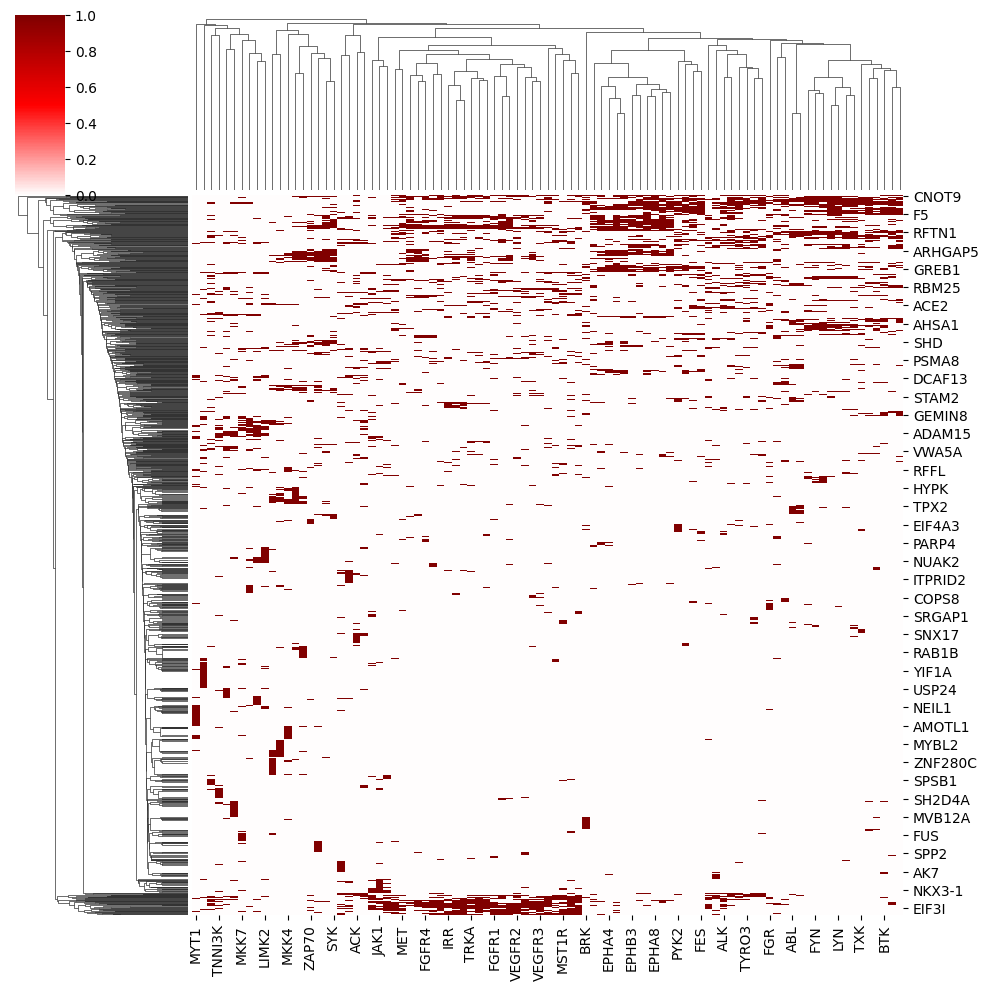

In [31]:
sns.clustermap(binarymatrix, cmap='seismic', center=0)

### Gene Similarity Clustered Heatmap

/Users/ido/opt/anaconda3/envs/harmonizomeETL/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ido/opt/anaconda3/envs/harmonizomeETL/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


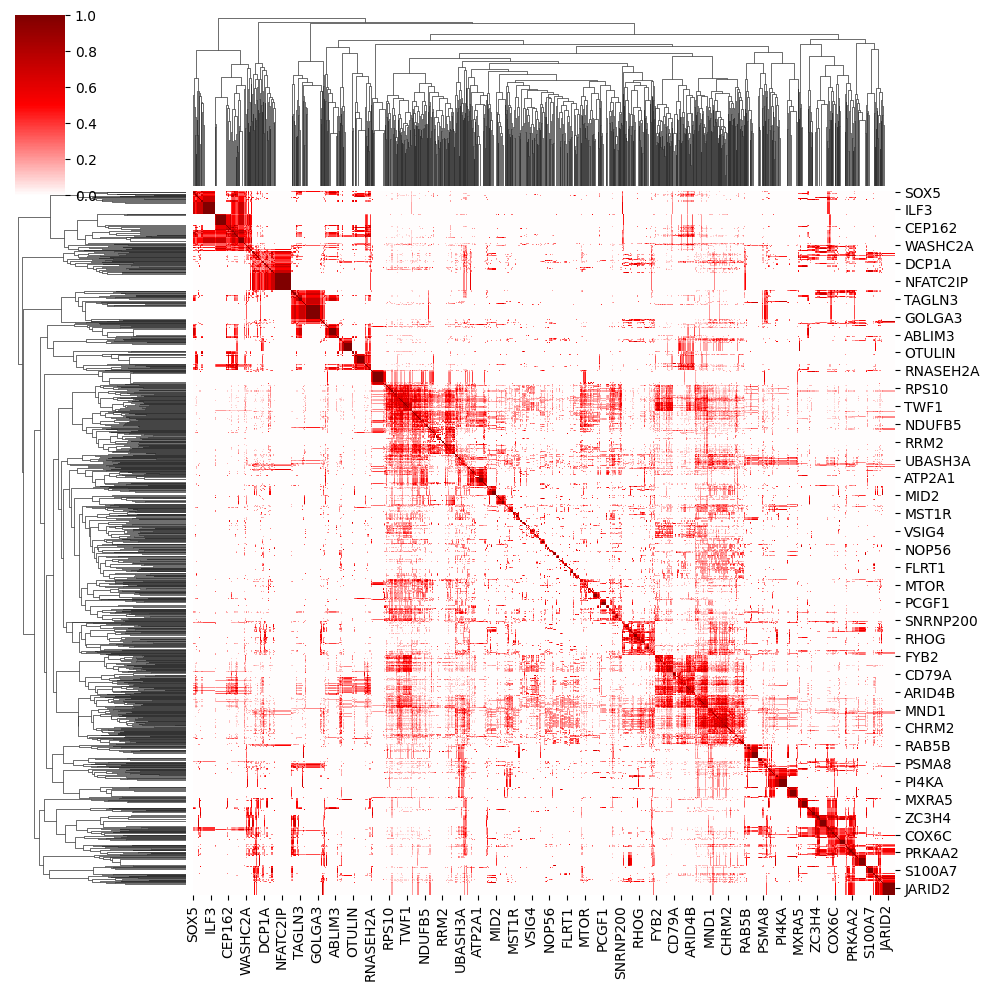

In [32]:
sns.clustermap(gene_similarity_matrix, cmap='seismic', center=0)

### Attribute Similarity Clustered Heatmap

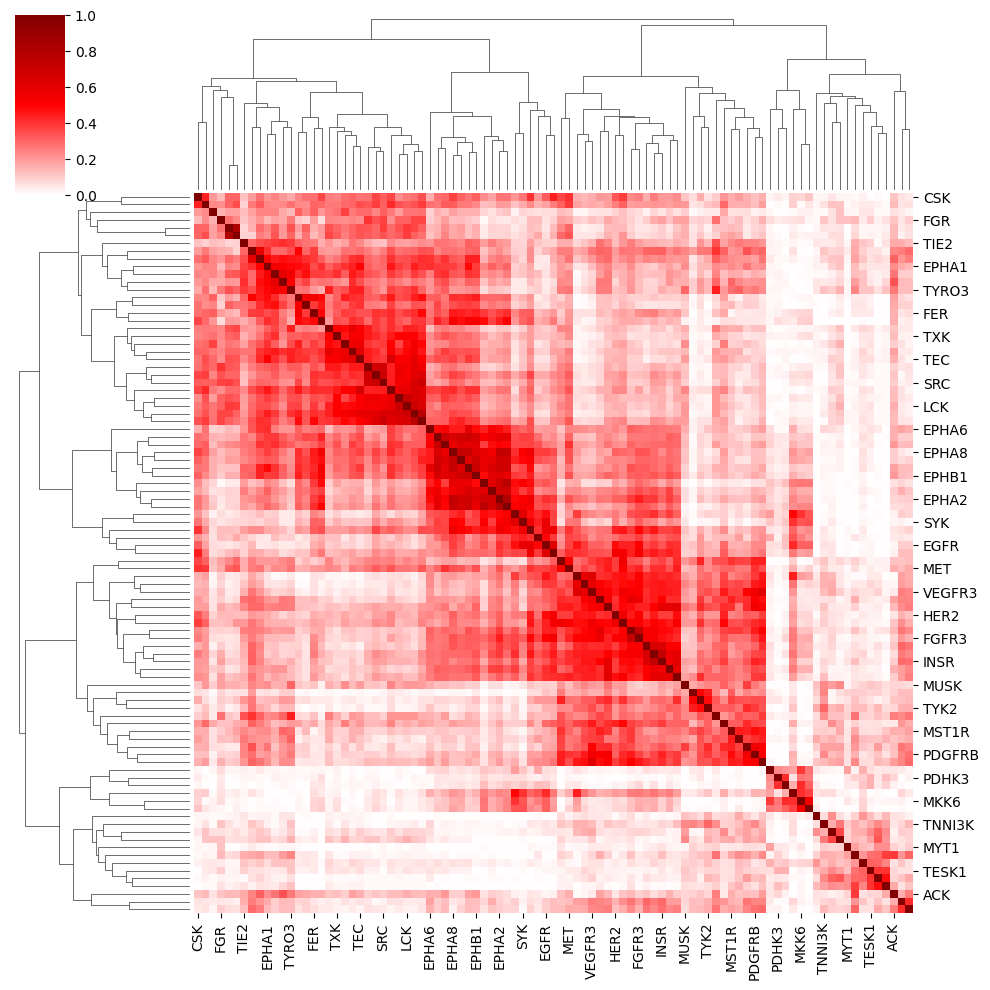

In [33]:
sns.clustermap(attribute_similarity_matrix, cmap='seismic', center=0)

### UMAP

In [34]:
def load_gmt(file):
    gmt = OrderedDict()
    for line in file:
        term, blank, *geneset = line.strip().split('\t')
        gmt[term] = ' '.join(set(geneset))
    return gmt
libdict = load_gmt(open(output_path+'gene_set_library_crisp.gmt', 'r'))

scatterdir = 'TyrKinome/images/'

In [35]:
def process_scatterplot(libdict, nneighbors=30, mindist=0.1, spread=1.0, maxdf=1.0, mindf=1):
    print("\tTF-IDF vectorizing gene set data...")
    vec = TfidfVectorizer(max_df=maxdf, min_df=mindf)
    X = vec.fit_transform(libdict.values())
    print(X.shape)
    adata = anndata.AnnData(X)
    adata.obs.index = libdict.keys()

    print("\tPerforming Leiden clustering...")
    ### the n_neighbors and min_dist parameters can be altered
    sc.pp.neighbors(adata, n_neighbors=nneighbors)
    sc.tl.leiden(adata, resolution=1.0)
    sc.tl.umap(adata, min_dist=mindist, spread=spread, random_state=42)

    new_order = adata.obs.sort_values(by='leiden').index.tolist()
    adata = adata[new_order, :]
    adata.obs['leiden'] = 'Cluster ' + adata.obs['leiden'].astype('object')

    df = pd.DataFrame(adata.obsm['X_umap'])
    df.columns = ['x', 'y']

    df['cluster'] = adata.obs['leiden'].values
    df['term'] = adata.obs.index
    df['genes'] = [libdict[l] for l in df['term']]

    return df

In [38]:
def get_scatter_colors(df):
    clusters = pd.unique(df['cluster']).tolist()
    colors = list(Category20[20])[::2] + list(Category20[20])[1::2]
    color_mapper = {clusters[i]: colors[i % 20] for i in range(len(clusters))}
    return color_mapper

def get_scatterplot(scatterdf):
    df = scatterdf.copy()
    color_mapper = get_scatter_colors(df)
    df['color'] = df['cluster'].apply(lambda x: color_mapper[x])

    hover_emb = HoverTool(name="df", tooltips="""
        <div style="margin: 10">
            <div style="margin: 0 auto; width:300px;">
                <span style="font-size: 12px; font-weight: bold;">Gene Set:</span>
                <span style="font-size: 12px">@gene_set</span>
            <div style="margin: 0 auto; width:300px;">
                <span style="font-size: 12px; font-weight: bold;">Coordinates:</span>
                <span style="font-size: 12px">(@x,@y)</span>
            <div style="margin: 0 auto; width:300px;">
                <span style="font-size: 12px; font-weight: bold;">Cluster:</span>
                <span style="font-size: 12px">@cluster</span>
            </div>
        </div>
    """)
    tools_emb = [hover_emb, 'pan', 'wheel_zoom', 'reset', 'save']

    plot_emb = figure(
        width=1000, 
        height=700, 
        tools=tools_emb
    )

    source = ColumnDataSource(
        data=dict(
            x = df['x'],
            y = df['y'],
            gene_set = df['term'],
            cluster = df['cluster'],
            colors = df['color'],
            label = df['cluster']
        )
    )

    # hide axis labels and grid lines
    plot_emb.xaxis.major_tick_line_color = None
    plot_emb.xaxis.minor_tick_line_color = None
    plot_emb.yaxis.major_tick_line_color = None
    plot_emb.yaxis.minor_tick_line_color = None
    plot_emb.xaxis.major_label_text_font_size = '0pt'
    plot_emb.yaxis.major_label_text_font_size = '0pt' 

    plot_emb.output_backend = "svg"    
    
    plot_emb.title = 'Gene Sets in the Kinase Library Tyrosine Kinome Atlas Library'
    plot_emb.xaxis.axis_label = "UMAP_1"
    plot_emb.yaxis.axis_label = "UMAP_2"
    plot_emb.xaxis.axis_label_text_font_style = 'normal'
    plot_emb.xaxis.axis_label_text_font_size = '18px'
    plot_emb.yaxis.axis_label_text_font_size = '18px'
    plot_emb.yaxis.axis_label_text_font_style = 'normal'
    plot_emb.title.align = 'center'
    plot_emb.title.text_font_size = '18px'
    
    s = plot_emb.scatter(
        'x', 
        'y', 
        size = 4, 
        source = source, 
        color = 'colors'
    )
    
    return plot_emb

In [39]:
## defaults: nneighbors=30, mindist=0.1, spread=1.0, maxdf=1.0, mindf=1
scatter_df = process_scatterplot(libdict, 
     nneighbors=4,
     #mindist=0.01
     spread=1.0,
     #,maxdf=0.5
     #,mindf=2
)

# Display Scatter Plot
plot = get_scatterplot(scatter_df)
output_notebook()
show(plot)

	TF-IDF vectorizing gene set data...
(93, 1459)
	Performing Leiden clustering...
         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/ido/opt/anaconda3/envs/harmonizomeETL/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/var/folders/rt/nqdq0c4n0qn85yvwrldftq480000gn/T/ipykernel_61857/3209109839.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['leiden'] = 'Cluster ' + adata.obs['leiden'].astype('object')


Loading BokehJS ...

In [41]:
# save HTML if desired
output_file(filename=f"{scatterdir}/umap.html", title = 'Gene Sets in Kinase Library Tyrosine Kinome Atlas Library')
save(plot)

'/Users/ido/Documents/harmonizome/newdata/KinaseLibrary/TyrKinome/images/umap.html'